<a href="https://colab.research.google.com/github/caroldaza/DM_CyT/blob/main/EEG_microstates_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importa paquetes



In [97]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import matplotlib.gridspec as gridspec
import scipy
from scipy.signal import butter, lfilter
import scipy.spatial.distance as d
from sklearn import decomposition
import seaborn as sns; sns.set_theme()
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler
import pylab
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import adjusted_rand_score
from sklearn.neighbors import NearestNeighbors

Bajo paquete para trabajar con EEG- Me permite ver la topografía

In [3]:
!pip install mne
import mne

     |████████████████████████████████| 6.9 MB 3.7 MB/s 


In [4]:
import random 
random.seed(123) 

# (0) Levanto datos de EEG

El registro de EEG de 30 canales viene en formato txt. La frecuencia de muestreo es de 128 Hz.

In [5]:
filename = '/content/drive/MyDrive/procesados/suj_8_bl_1.txt'
datos = pd.read_csv(filename, sep=',', header=None)
EEGdata_0 = datos.to_numpy()
srate=128
ch    = EEGdata_0.shape[0]
samples = EEGdata_0.shape[1] 

print("Sampling rate: {:.2f} Hz".format(srate))
print("Data shape: {:d} samples x {:d} channels".format(EEGdata_0.shape[1], EEGdata_0.shape[0]))
print("Tiempo total : {:.2f} ".format(samples/srate))

Sampling rate: 128.00 Hz
Data shape: 7681 samples x 30 channels
Tiempo total : 60.01 


In [6]:
# Montage 10-20
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Elijo canales que tengo
kept_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 
                 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2',
                 'FC5', 'FC6','CP1','CP2','CP5','CP6','AFz','Fpz','POz']

ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_30 = mont1020.copy()
# Me quedo solo con los canales seleccionados
mont1020_30.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Me quedo con las referencias desde dónde están ubicados los canales
mont1020_30.dig = mont1020.dig[0:3]+kept_channel_info
info_eeg = mne.create_info(ch_names=mont1020_30.ch_names, sfreq=128,
                            ch_types='eeg').set_montage(mont1020_30)

# (1) Inspección de los datos

Los datos ya vienen limpios y filtrados entre 2 y 20 Hz

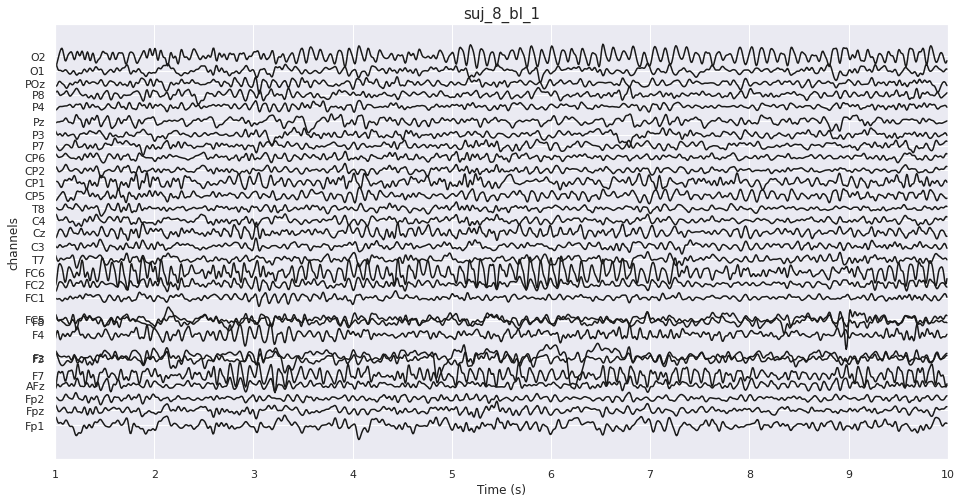

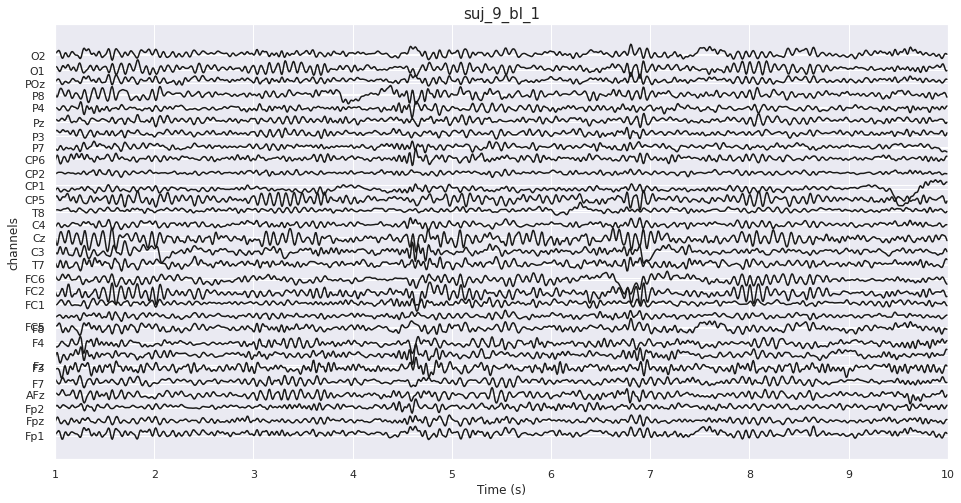

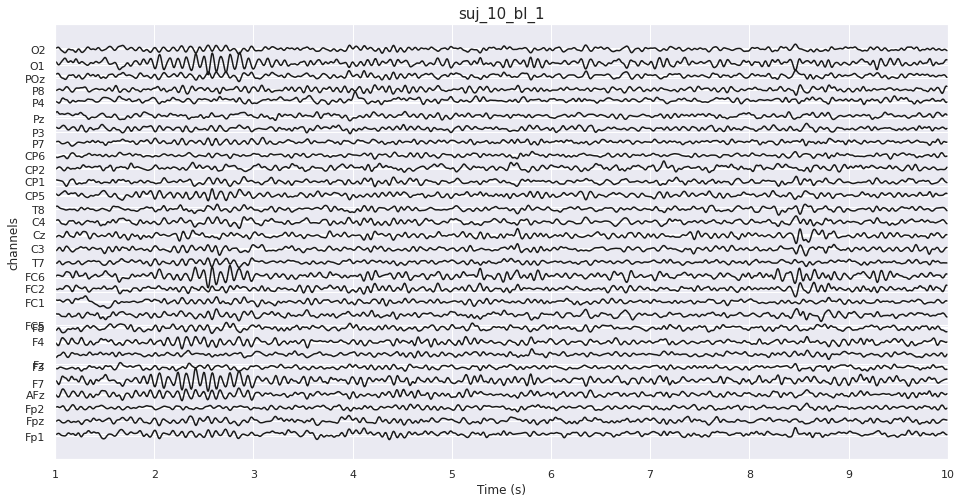

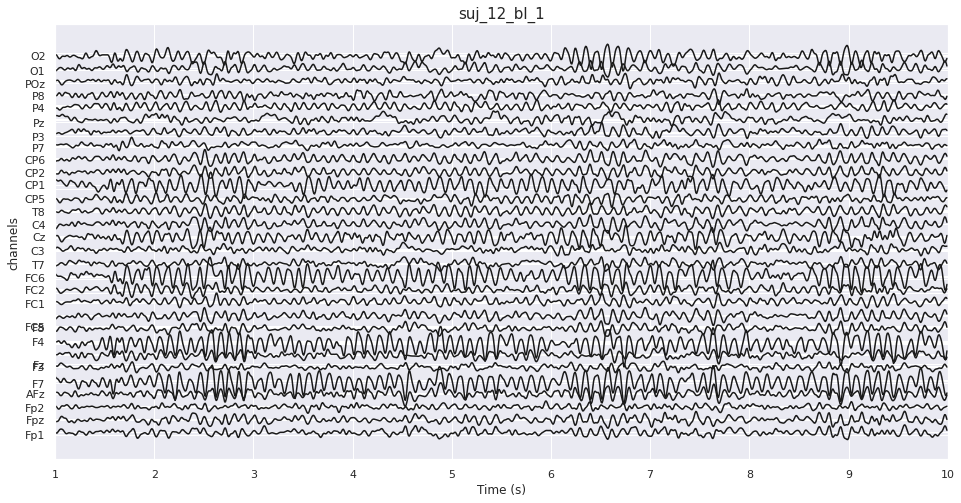

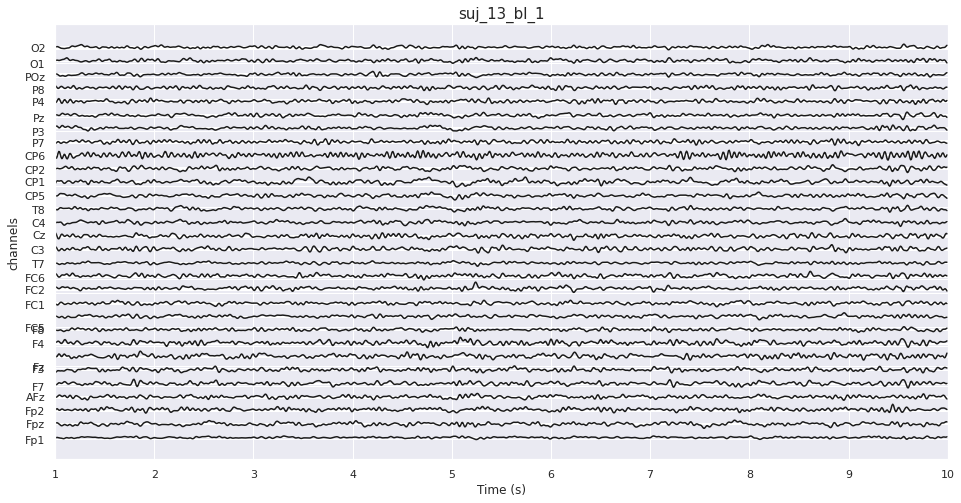

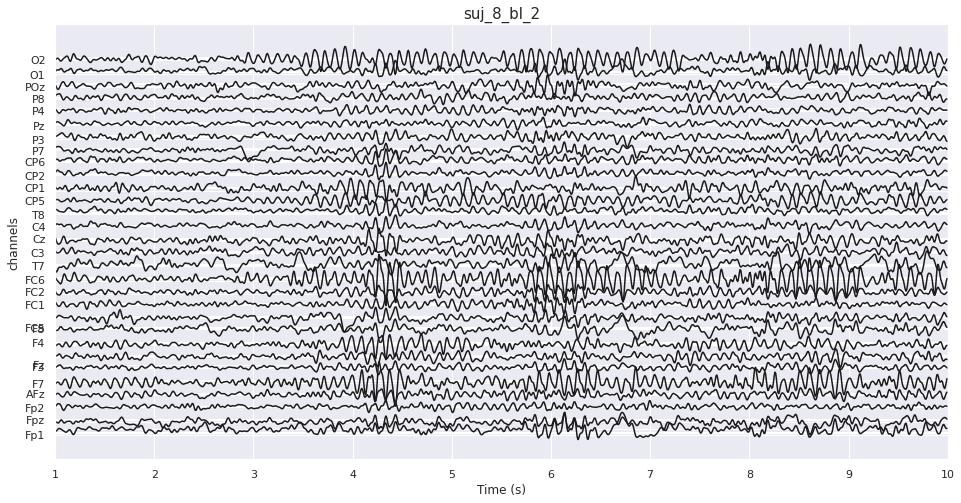

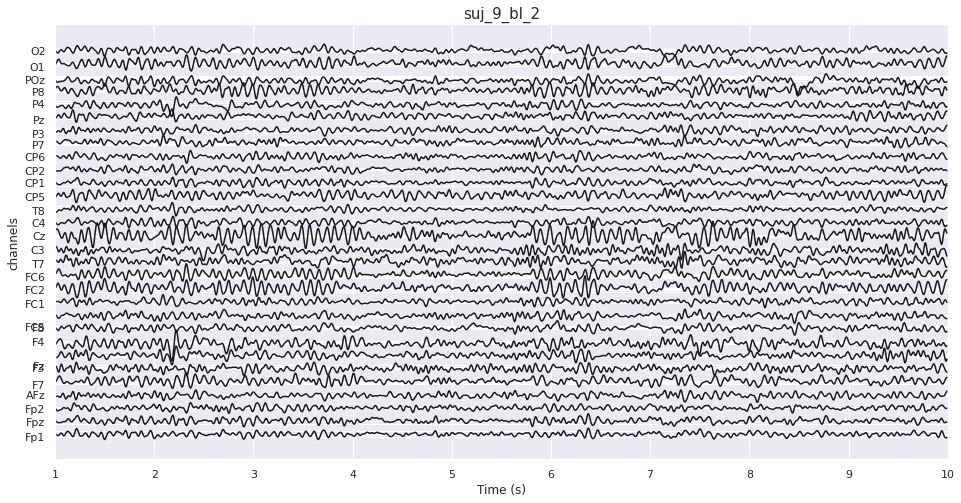

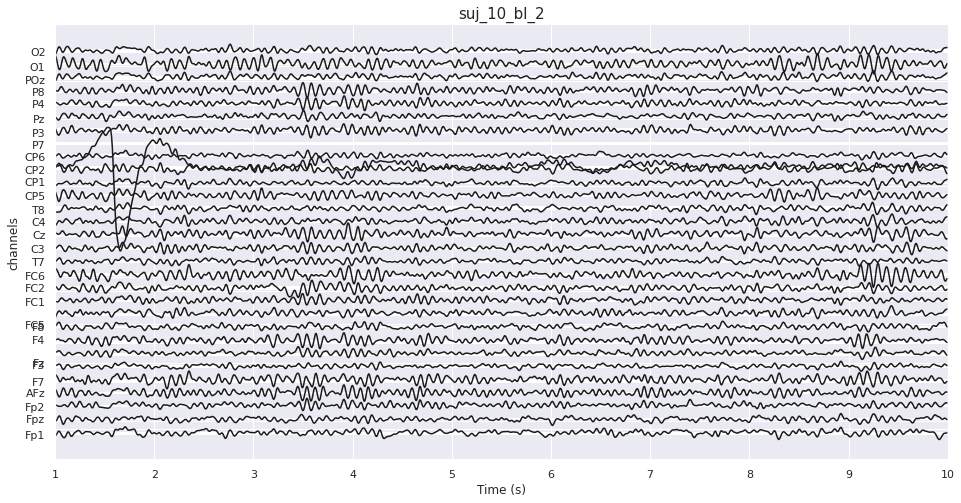

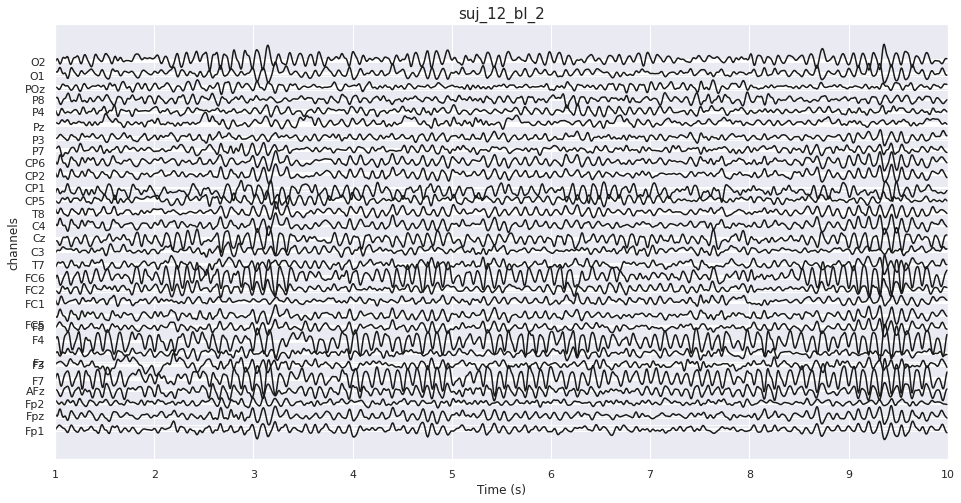

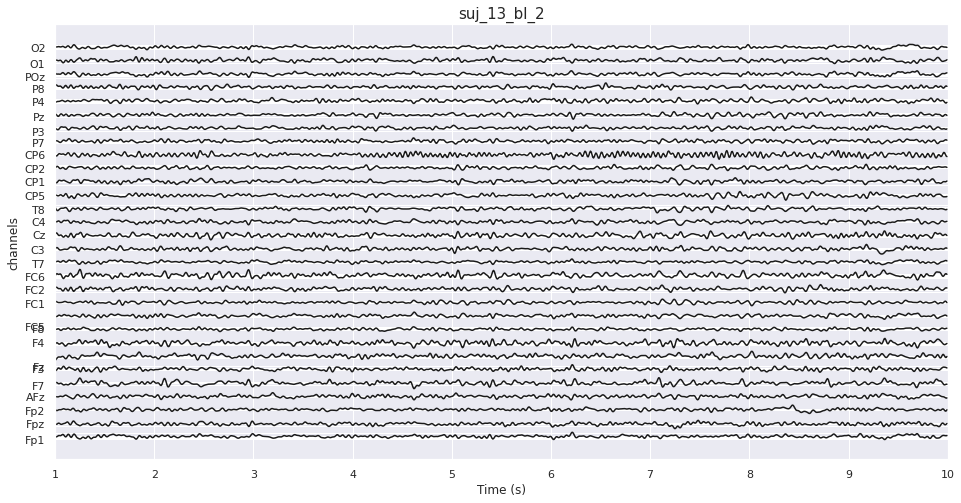

In [7]:
subject = [8,9,10,12,13] 
periodo = [1,2]
srate=128

inicio = 1
fin    = 10
xticks = np.arange(inicio*srate,(fin+1)*srate,srate)
yticks=[]

for per in range(1,3):
  for ind,sub in enumerate(subject):
    filename = '/content/drive/MyDrive/procesados/suj_' + str(sub) + '_bl_' + str(per) + '.txt'

    datos = pd.read_csv(filename, sep=',', header=None)
    EEGdata = datos.to_numpy()
    ch    = EEGdata.shape[0]
    samples = EEGdata.shape[1] 

    
    fig,ax = plt.subplots(ncols=1,figsize=(16,8))
    
    for c in np.arange(ch):
        temp = EEGdata[c,inicio*srate:fin*srate]
        dmin=np.min(temp)
        dmax=np.max(temp)
        vmedio = np.mean([dmin,dmax])+30*c
        yticks.append(vmedio)
        ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp)+temp,'k')
        
    ax.set_xlim([inicio*srate,fin*srate])
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.arange(inicio,fin+1))
    ax.set_yticks(yticks)
    ax.set_yticklabels(mont1020_30.ch_names)
    ax.set_ylabel('channels')
    ax.set_xlabel('Time (s)')
    name = 'suj_' + str(sub) + '_bl_' + str(per) 
    ax.set_title(name , fontsize=15)
      
    plt.show()




El sujeto 13 parece ser especial

## (1.1) Topografía media

Topología


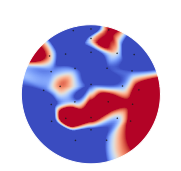

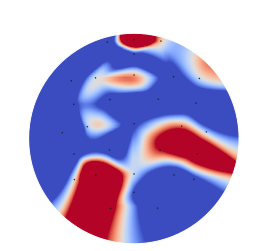

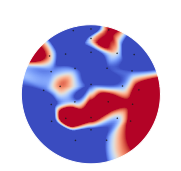

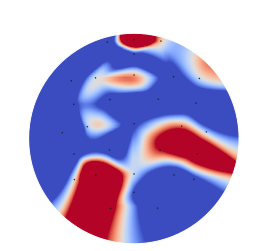

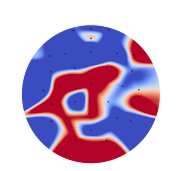

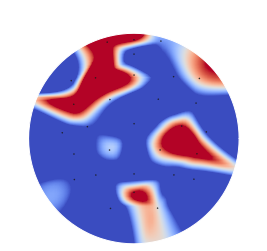

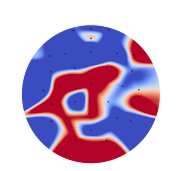

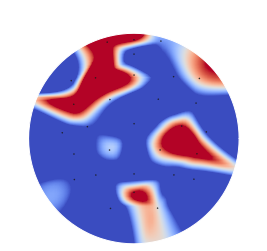

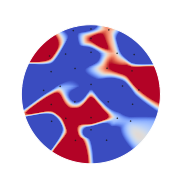

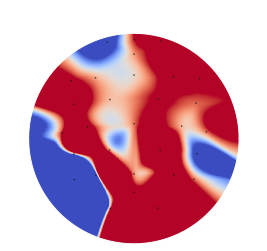

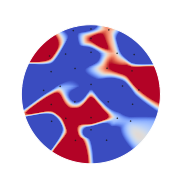

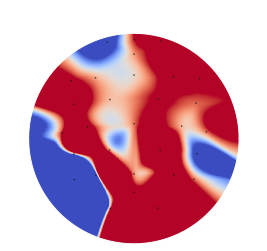

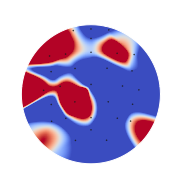

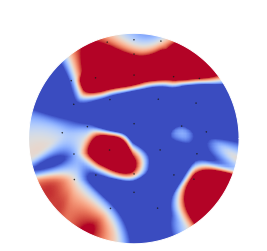

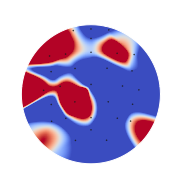

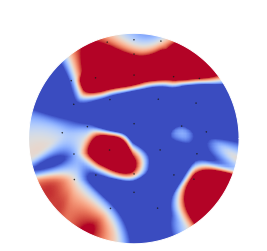

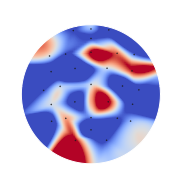

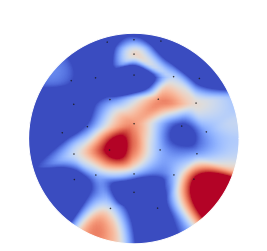

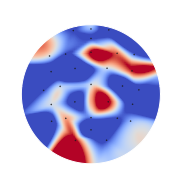

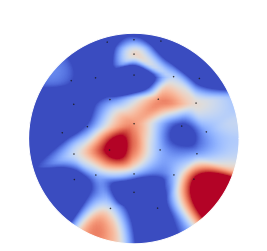

In [8]:
subject = [8,9,10,12,13] 
periodo = [1,2]
srate=128

inicio = 1
fin    = 2

for ind,sub in enumerate(subject):
  for per in range(1,3):
    filename1 = '/content/drive/MyDrive/procesados/suj_' + str(sub) + '_bl_1.txt'
    filename2 = '/content/drive/MyDrive/procesados/suj_' + str(sub) + '_bl_2.txt'

    #print(filename1)
    #print(filename2)

    datos1 = pd.read_csv(filename1, sep=',', header=None)
    datos2 = pd.read_csv(filename2, sep=',', header=None)
    EEGdata1 = datos1.to_numpy()
    EEGdata2 = datos2.to_numpy()
    #ch    = EEGdata.shape[0]
    #samples = EEGdata.shape[1] 


    fig, ax = plt.subplots(figsize=(3, 3),gridspec_kw=dict(top=0.9),sharex=True,sharey=True)

    name = 'suj_' + str(sub) + '_bl_' + str(per) 

    ax,cm1   = mne.viz.plot_topomap(EEGdata1[:,inicio*srate:fin*srate].mean(axis=1),info_eeg,vmin=-0.05,vmax=0.3,
                      cmap='coolwarm', contours=0, show=True)
    ax,cm2   = mne.viz.plot_topomap(EEGdata2[:,inicio*srate:fin*srate].mean(axis=1),info_eeg,vmin=-0.05,vmax=0.3,
                      cmap='coolwarm', contours=0, show=True)
      
  #ax.set_title('topogragía promedio')
  #ax_x_start = 0.95
  #ax_x_width = 0.04
  #ax_y_start = 0.1
  #ax_y_height = 0.9
  #cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
  #clb = fig.colorbar(ax, cax=cbar_ax)
  
  #ax.set_title(name , fontsize=15)    


## Medicion distancia primer bloque
Calcularemos el promedio de las mediciones de cada sujeto durante el primer segundo en la pre-tarea

In [9]:
promedios_bl_1_1s = []

inicio = 1 
fin    = 2  

for ind,sub in enumerate(subject):  
  filename1 = '/content/drive/MyDrive/procesados/suj_' + str(sub) + '_bl_1.txt'        
  datos1 = pd.read_csv(filename1, sep=',', header=None)    
  EEGdata1 = datos1.to_numpy()   
  EEGdata1_1seg = EEGdata1[:,inicio*srate:fin*srate]        
  medias_fila = EEGdata1_1seg.mean(axis=1)    
  promedios_bl_1_1s.append(medias_fila)
  

In [10]:
df_1s = pd.DataFrame(promedios_bl_1_1s, columns= kept_channels, dtype = float) 
df_1s

Fp1       Fp2        F3  ...       AFz       Fpz       POz
0 -0.797705 -0.432769  0.312478  ... -0.104407 -0.742257 -0.023064
1 -0.071581 -0.090876 -0.166033  ... -0.226157  0.387720  0.258854
2 -0.120162 -0.094653  0.217349  ... -0.320650  0.604743 -0.388247
3  0.153329 -0.220583 -0.104933  ... -0.181651 -0.102295 -0.632349
4 -0.054113  0.034422 -0.172250  ... -0.338847  0.322875 -0.066600

[5 rows x 30 columns]

### Cálculo de la distancia euclidea

In [11]:
ary = scipy.spatial.distance.cdist(df_1s.iloc[:,1:], df_1s.iloc[:,1:], metric='euclidean')
ary.round(3)

array([[0.   , 2.5  , 2.347, 2.936, 2.032],
       [2.5  , 0.   , 2.438, 3.721, 2.194],
       [2.347, 2.438, 0.   , 3.213, 1.991],
       [2.936, 3.721, 3.213, 0.   , 2.633],
       [2.032, 2.194, 1.991, 2.633, 0.   ]])

Text(0.5, 1.0, 'Distancia euclídea')

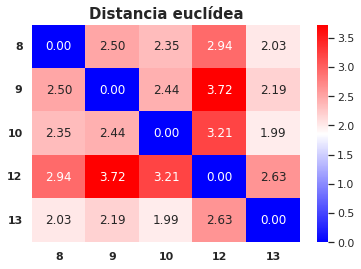

In [12]:
ax = sns.heatmap(ary, annot=True,cmap="bwr", fmt=".2f")
labels_cm = ["8", "9", "10", "12", "13"]
ax.xaxis.set_ticklabels(labels_cm,fontweight="bold")
ax.yaxis.set_ticklabels(labels_cm,fontweight="bold",rotation=0)
plt.title("Distancia euclídea", fontsize =15,fontweight="bold")

### Cálculo de la distancia de Manhattan

In [13]:
def CityBlock_distance(A, B):
	result = d.cdist(A, B, 'cityblock')
	return result

manhattan_dist = CityBlock_distance(df_1s, df_1s)
print(manhattan_dist.round(3))

[[ 0.    11.552 10.029 13.835  9.682]
 [11.552  0.    11.089 15.373  9.422]
 [10.029 11.089  0.    14.028  8.78 ]
 [13.835 15.373 14.028  0.    10.511]
 [ 9.682  9.422  8.78  10.511  0.   ]]


Text(0.5, 1.0, 'Distancia de Manhattan')

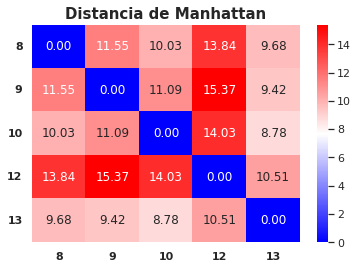

In [14]:
ax = sns.heatmap(manhattan_dist, annot=True,cmap="bwr", fmt=".2f")
labels_hm = ["8", "9", "10", "12", "13"]
ax.xaxis.set_ticklabels(labels_hm,fontweight="bold")
ax.yaxis.set_ticklabels(labels_hm,fontweight="bold",rotation = 0)
plt.title("Distancia de Manhattan", fontsize =15,fontweight="bold")

## Medicion distancia segundo bloque
Calcularemos el promedio de las mediciones de cada sujeto durante el primer segundo en la post-tarea

In [15]:
promedios_bl_2_1s = []

inicio = 1 
fin    = 2  

for ind,sub in enumerate(subject):  
    filename2 = '/content/drive/MyDrive/procesados/suj_' + str(sub) + '_bl_2.txt'
    datos2 = pd.read_csv(filename2, sep=',', header=None)    
    EEGdata2 = datos2.to_numpy()   
    EEGdata2_1seg = EEGdata2[:,inicio*srate:fin*srate]        
    medias_fila = EEGdata2_1seg.mean(axis=1)      
    promedios_bl_2_1s.append(medias_fila)


In [16]:
df_1s_2 = pd.DataFrame(promedios_bl_2_1s, columns= kept_channels, dtype = float) 
df_1s_2

Fp1       Fp2        F3  ...       AFz       Fpz       POz
0 -0.261031  0.758761  0.156790  ... -0.077146  0.377369 -0.242631
1  0.389912  0.289716  0.000849  ...  0.308076 -0.348734  0.124072
2 -0.168786  0.295848  0.327207  ...  0.398309  0.342747  0.642832
3  0.273957  0.095297  0.149924  ... -0.498116  0.000512 -0.263015
4 -0.135491  0.003960 -0.183279  ... -0.251935  0.083821 -0.148397

[5 rows x 30 columns]

### Cálculo de la distancia euclidea

In [17]:
ary_2 = scipy.spatial.distance.cdist(df_1s_2.iloc[:,1:], df_1s_2.iloc[:,1:], metric='euclidean')
ary_2.round(3)

array([[0.   , 1.988, 8.695, 2.734, 2.125],
       [1.988, 0.   , 8.295, 2.295, 2.083],
       [8.695, 8.295, 0.   , 8.724, 8.168],
       [2.734, 2.295, 8.724, 0.   , 2.444],
       [2.125, 2.083, 8.168, 2.444, 0.   ]])

Text(0.5, 1.0, 'Distancia euclídea')

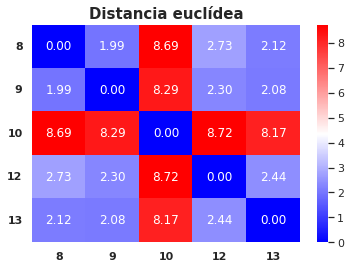

In [18]:
ax = sns.heatmap(ary_2, annot=True,cmap="bwr", fmt=".2f")
labels_cm = ["8", "9", "10", "12", "13"]
ax.xaxis.set_ticklabels(labels_cm,fontweight="bold")
ax.yaxis.set_ticklabels(labels_cm,fontweight="bold",rotation=0)
plt.title("Distancia euclídea", fontsize =15,fontweight="bold")

### Cálculo de la distancia de Manhattan

In [19]:
manhattan_dist = CityBlock_distance(df_1s_2, df_1s_2)
print(manhattan_dist.round(3))

[[ 0.     8.598 20.374 12.419  9.736]
 [ 8.598  0.    19.394 10.789 10.113]
 [20.374 19.394  0.    21.08  16.62 ]
 [12.419 10.789 21.08   0.     9.786]
 [ 9.736 10.113 16.62   9.786  0.   ]]


Text(0.5, 1.0, 'Distancia de Manhattan')

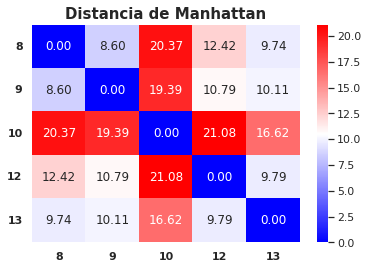

In [20]:
ax = sns.heatmap(manhattan_dist, annot=True,cmap="bwr", fmt=".2f")
labels_hm = ["8", "9", "10", "12", "13"]
ax.xaxis.set_ticklabels(labels_hm,fontweight="bold")
ax.yaxis.set_ticklabels(labels_hm,fontweight="bold",rotation = 0)
plt.title("Distancia de Manhattan", fontsize =15,fontweight="bold")

## Mediciones distancia sujetos entre periodos
### Cálculo de la distancia euclidea

In [21]:
ary_bl = scipy.spatial.distance.cdist(df_1s.iloc[:,1:], df_1s_2.iloc[:,1:], metric='euclidean')
ary_bl.round(3)

array([[2.48 , 2.408, 8.144, 2.897, 1.724],
       [2.523, 2.948, 8.427, 3.623, 1.888],
       [2.853, 3.33 , 7.977, 3.275, 1.911],
       [3.411, 2.789, 8.561, 2.078, 2.426],
       [2.037, 2.128, 8.155, 2.481, 1.147]])

In [22]:
eucl_dist_per = ary_bl.diagonal() # distancias entre mismo sujeto pre-tarea post-tarea
eucl_dist_per

array([2.48000817, 2.94774063, 7.97663982, 2.07771619, 1.14657841])

### Cálculo de la distancia de Manhattan

In [23]:
manhattan_dist = CityBlock_distance(df_1s, df_1s_2)
print(manhattan_dist.round(3))

[[10.476 12.035 18.943 14.141  8.037]
 [10.686 12.536 19.893 15.16   8.048]
 [12.976 16.191 19.805 14.526  8.554]
 [13.693 11.846 21.34   9.102 10.654]
 [ 8.688 10.345 16.833 10.106  4.79 ]]


In [24]:
manh_dist_per = manhattan_dist.diagonal() # distancias manhattan entre mismo sujeto pre-tarea post-tarea
manh_dist_per

array([10.47632396, 12.53592582, 19.80471282,  9.10217556,  4.79037693])

## (1.2) Descomposición (PCA-1)

Concatenando en tiempo para todos los sujetos:

(30, 3)
(30, 3)
(30, 3)
(30, 3)
(30, 3)


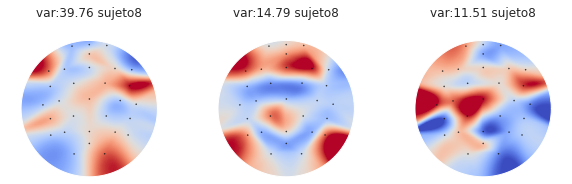

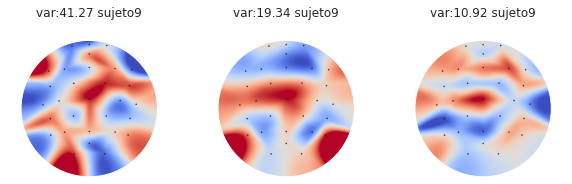

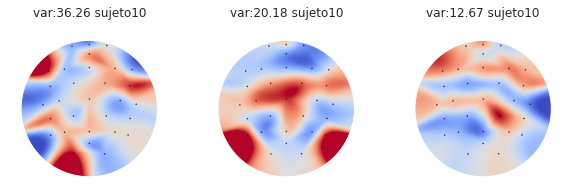

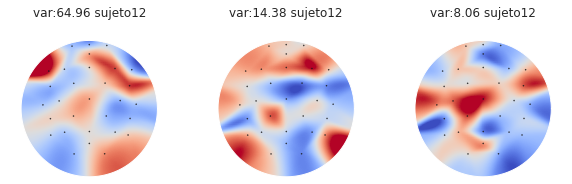

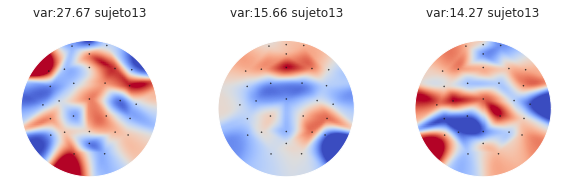

In [25]:
subject = [8,9,10,12,13] 
periodo = [1,2]
srate=128

inicio = 1
fin    = 10
i=0

varianzas_3comp = []
EEGdata_all = pd.DataFrame()

for ind,sub in enumerate(subject):
  for per in range(1,3):
    
    
    filename = '/content/drive/MyDrive/procesados/suj_' + str(sub) + '_bl_' + str(per) + '.txt'

    datos = pd.read_csv(filename, sep=',', header=None)
    EEGdata = datos.to_numpy()

    globals()['df' + str(i)] = EEGdata # esto crea variables df y les asigna dataframes que va leyendo
    i += 1

# pasar numpy array a dataset
# seguro hay una manera mas inteligente de escribir esto pero para rapidez
df0 = pd.DataFrame(df0) #s8 p1
df1 = pd.DataFrame(df1) #s8 p2
df2 = pd.DataFrame(df2) #s9 p1
df3 = pd.DataFrame(df3) #s9 p2
df4 = pd.DataFrame(df4) #s10 p1
df5 = pd.DataFrame(df5) #s10 p2
df6 = pd.DataFrame(df6) #s12 p1
df7 = pd.DataFrame(df7) #s12 p2
df8 = pd.DataFrame(df8) #s13 p1
df9 = pd.DataFrame(df9) #s13 p2

# Concateno pre y post por sujeto

frames1 = [df0,df1]  
frames2 = [df2,df3]
frames3 = [df4,df5]
frames4 = [df6,df7]
frames5 = [df8,df9]

for i, sub in enumerate(subject):
  EEGdata_all_times = pd.concat(globals()['frames'+str(i+1)],axis=1) #concatenando dos periodos en un sujeto

  #PCA
  pca = decomposition.PCA(n_components=3)
  pca.fit(EEGdata_all_times)
  pcs = pca.transform(EEGdata_all_times)
  print(pcs.shape)
  
  var = pca.explained_variance_ratio_

  varianzas_3comp.append(var)

  fig2, ax = plt.subplots(ncols=pcs.shape[1], figsize=(10, 3), gridspec_kw=dict(top=0.9),
                      sharex=True, sharey=True)

  for p in range(pcs.shape[1]):
    mne.viz.plot_topomap(pcs[:,p],
                      info_eeg,
                      cmap='coolwarm', contours=0,
                      axes=ax[p],show=False)
    ax[p].set_title('var:'+str(round(var[p]*100,2))+' '+'sujeto'+str(sub))  



***AQUI HABRÍA QUE COMPARAR CON UNA MEDIDA DE DISTANCIA TAMBIÉN***

In [26]:
varianzas_3comp

[array([0.39762413, 0.14786792, 0.11514557]),
 array([0.41267583, 0.19338503, 0.10922598]),
 array([0.36256934, 0.20182445, 0.12669893]),
 array([0.64957057, 0.14377719, 0.08060721]),
 array([0.27671812, 0.15664415, 0.14272025])]

In [27]:
np.sum(varianzas_3comp,axis=1) # varianza total explicada 3 componentes (para checkear resultados de abajo)

array([0.66063763, 0.71528684, 0.69109272, 0.87395496, 0.57608252])

In [28]:
# Calculando los totales de la varianza explicada para cada sujeto variando el numero de componentes de pca

varianzas = np.zeros((5,6))

for i, sub in enumerate(subject):
  EEGdata_all_times = pd.concat(globals()['frames'+str(i+1)],axis=1) #concatenando sujetos

  for j in range(0,6):  # loop para componentes pca

    vary = []
    #PCA
    pca = decomposition.PCA(n_components=j+1)
    pca.fit(EEGdata_all_times)
    pcs = pca.transform(EEGdata_all_times)
    
    var = pca.explained_variance_ratio_
    vary.append(var)

    varianzas[i,j] = np.sum(vary,axis=1)  # total varianza explicada j componentes en sujeto i


varianzas

array([[0.39762413, 0.54549206, 0.66063763, 0.73070482, 0.77978944,
        0.81598117],
       [0.41267583, 0.60606086, 0.71528684, 0.77049613, 0.81668314,
        0.84697387],
       [0.36256934, 0.56439379, 0.69109272, 0.7897244 , 0.84042496,
        0.86306129],
       [0.64957057, 0.79334775, 0.87395496, 0.90101496, 0.92601409,
        0.93963412],
       [0.27671812, 0.43336227, 0.57608252, 0.64307168, 0.69313538,
        0.72740184]])

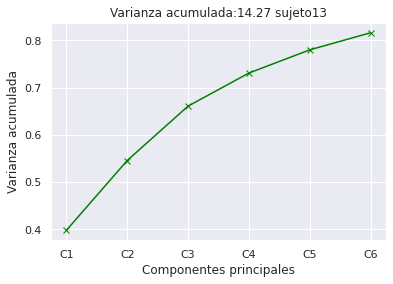

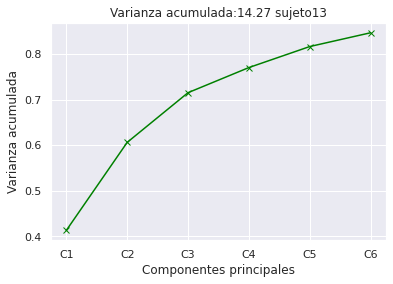

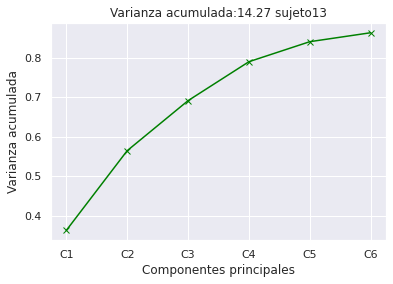

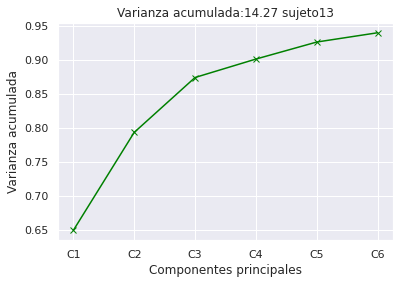

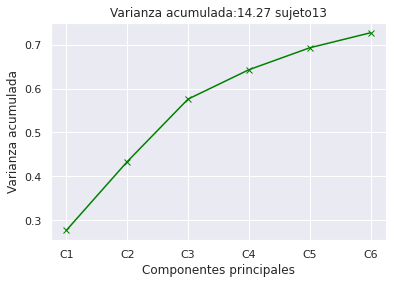

In [29]:
for i in range(5):
  plt.plot(['C1', 'C2', 'C3', 'C4', 'C5', 'C6'], varianzas[i], color='green', marker = 'x')
  plt.ylabel('Varianza acumulada')
  plt.xlabel('Componentes principales')
  plt.title('Varianza acumulada:'+str(round(var[p]*100,2))+' '+'sujeto'+str(sub))
  plt.show()

# (2) Cálculo del Global Field Power

In [30]:
#
for i, sub in enumerate(subject):
  EEGdata_all_times = pd.concat(globals()['frames'+str(i+1)],axis=1) #concatenando por columnas (los dos periodos un sujeto)

  media = np.mean(EEGdata_all_times, axis=0)  # la media entre los 30 canales
  referenciado_cuad = np.square(EEGdata_all_times.subtract(media, axis=1)) # restando la media de todas las filas y elevando a 2
  globals()['GFP'+ str(sub)] = np.sqrt((1/30)*np.sum(referenciado_cuad, axis=0)) #sqrt(k*sum((ui-mean(u))^2)) suma sobre columnas



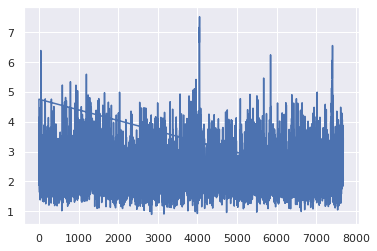

In [31]:
plt.plot(GFP13 )

In [32]:
GFP10

0       4.072512
1       4.682868
2       5.190481
3       5.935945
4       6.849898
          ...   
7676    3.580176
7677    4.654494
7678    6.093395
7679    6.515780
7680    5.443500
Length: 15362, dtype: float64

# (2.1) Calculo de los picos del GFP

In [33]:
from scipy.signal import find_peaks 
subject = [8,9,10,12,13] 
indices_peaks = []

# indices de los picos para cada GFP
for ind,sub in enumerate(subject):
  y = globals()['GFP' + str(sub)]
  picos = find_peaks(y, height=0)
  indices_peaks.append(picos[0])


In [34]:
indices_peaks

[array([    2,     7,    16, ..., 15341, 15348, 15356]),
 array([    1,     9,    14, ..., 15348, 15352, 15359]),
 array([    5,    10,    17, ..., 15344, 15351, 15360]),
 array([    3,     8,    15, ..., 15344, 15351, 15357]),
 array([    6,    11,    18, ..., 15342, 15351, 15357])]

In [35]:
len(indices_peaks[4])

2763

In [36]:
EEGdata_all_times.iat[1,5]

1.266

In [37]:
EEGdata_all_times_matrix = EEGdata_all_times.to_numpy()
EEGdata_all_times_matrix[1,5]

1.266

In [38]:
# Aqui se recuperan para cada sujeto una matriz cuyas columnas son el EEG en cada punto del GDP

for i, sub in enumerate(subject):
  EEGdata_all_times = pd.concat(globals()['frames'+str(i+1)],axis=1) #concatenando por columnas

  EEGdata_all_times_matrix = EEGdata_all_times.to_numpy() # lo paso a matriz para accederlo mas facil
  globals()['EEG_GFP_vectors_' + str(sub)] = EEGdata_all_times_matrix[:,indices_peaks[i]]


In [39]:
EEG_GFP_vectors_13 # los vectores a clusterizar son las columnas de estas matrices

array([[ 0.44567,  0.89402,  0.48766, ..., -1.6615 ,  2.4908 ,  2.3982 ],
       [ 2.1799 ,  5.7739 , -3.5536 , ..., -2.0772 ,  2.9709 ,  2.3654 ],
       [ 5.0301 ,  1.4424 , -2.6422 , ..., -1.1081 ,  1.6215 ,  0.46011],
       ...,
       [ 0.1804 ,  1.7349 , -2.8029 , ..., -2.4303 ,  3.9204 ,  0.69678],
       [-2.1131 , -2.4785 ,  1.6716 , ..., -1.4188 ,  0.97903, -5.9976 ],
       [ 0.49955,  0.74695, -1.9537 , ..., -1.2481 ,  1.1826 ,  2.647  ]])

In [40]:
EEG_GFP_vectors_13.shape[0], EEG_GFP_vectors_13.shape[1]
# 30 canales, 2763 puntos para sujeto 13

(30, 2763)

Text(0, 0.5, 'GFP13')

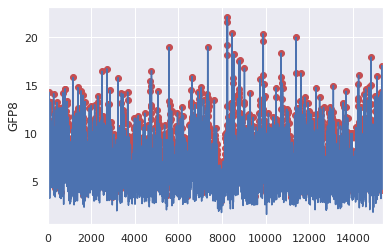

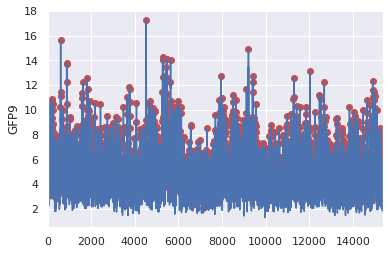

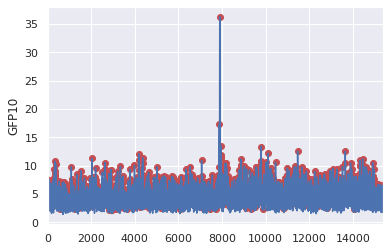

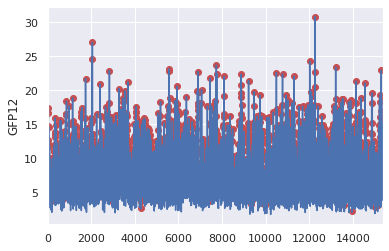

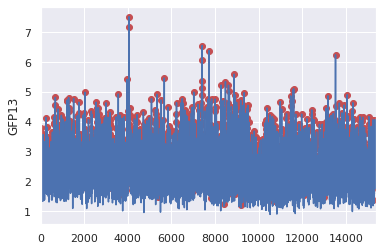

In [41]:
plt.figure()
x=np.arange(0,len(GFP8))
plt.plot(indices_peaks[0],GFP8.values[indices_peaks[0]],'ro')
plt.plot(x, GFP8)
plt.xlim(min(x),max(x))
plt.ylabel('GFP8')

plt.figure()
x=np.arange(0,len(GFP9))
plt.plot(indices_peaks[1],GFP9.values[indices_peaks[1]],'ro')
plt.plot(x, GFP9)
plt.xlim(min(x),max(x))
plt.ylabel('GFP9')

plt.figure()
x=np.arange(0,len(GFP10))
plt.plot(indices_peaks[2],GFP10.values[indices_peaks[2]],'ro')
plt.plot(x, GFP10)
plt.xlim(min(x),max(x))
plt.ylabel('GFP10')

plt.figure()
x=np.arange(0,len(GFP12))
plt.plot(indices_peaks[3],GFP12.values[indices_peaks[3]],'ro')
plt.plot(x, GFP12)
plt.xlim(min(x),max(x))
plt.ylabel('GFP12')

plt.figure()
x=np.arange(0,len(GFP13))
plt.plot(indices_peaks[4],GFP13.values[indices_peaks[4]],'ro')
plt.plot(x, GFP13)
plt.xlim(min(x),max(x))
plt.ylabel('GFP13')


La matriz concatenando todos los GFP:

In [42]:
GFP_all = np.concatenate((GFP8.to_numpy(),GFP9.to_numpy(),GFP10.to_numpy(),GFP12.to_numpy(),GFP13.to_numpy()),axis=0).reshape(-1,GFP8.shape[0])
GFP_all

array([[ 8.40511394,  9.85753436, 10.46554457, ...,  6.54394427,
        10.79554469, 13.25493778],
       [ 4.85285993,  5.30441728,  5.0411682 , ...,  4.39767427,
         4.07220214,  4.21476129],
       [ 4.07251224,  4.6828683 ,  5.19048097, ...,  6.0933952 ,
         6.51578027,  5.44349955],
       [ 5.28356054,  6.29932264, 10.12326763, ...,  6.29153947,
         4.19375489,  4.23948855],
       [ 3.28706985,  2.33577089,  1.87711097, ...,  2.04346296,
         2.03816088,  3.46150776]])

In [43]:
GFP_all.shape[0], GFP_all.shape[1]

(5, 15362)

In [44]:
type(GFP_all)

numpy.ndarray

La matriz concatenando todas las matrices de picos de cada sujeto (estos son los mapas):

In [45]:
EEG_vectors_all = np.concatenate((EEG_GFP_vectors_8,EEG_GFP_vectors_9,EEG_GFP_vectors_10,EEG_GFP_vectors_12,EEG_GFP_vectors_13),axis=1)
EEG_vectors_all.shape[0],EEG_vectors_all.shape[1]

(30, 13133)

In [46]:
EEG_GFP_vectors_8.shape[1],EEG_GFP_vectors_9.shape[1],EEG_GFP_vectors_10.shape[1],EEG_GFP_vectors_12.shape[1],EEG_GFP_vectors_13.shape[1]

(2631, 2787, 2589, 2363, 2763)

In [47]:
type(EEG_vectors_all)

numpy.ndarray

#(3) Clusterización

In [48]:
Todo_EEG_p=pd.concat([df0,df1,df2,df3,df4,df5,df6,df7,df8,df9],axis=1) # Todas los EEG juntos
Todo_EEG = Todo_EEG_p.to_numpy()

In [49]:
Todo_GFP = np.concatenate([EEG_GFP_vectors_8, EEG_GFP_vectors_9, EEG_GFP_vectors_10, EEG_GFP_vectors_12, EEG_GFP_vectors_13],axis=1) # Todas los GFP juntos
Todo_GFP_p = pd.DataFrame(Todo_GFP)

## (3.1) Dendrograma 

In [50]:
data = Todo_GFP_p.sample(frac=1).reset_index(drop=True) # aleatorizando, frac es la proporcion de filas que devuelve

#df = StandardScaler().fit_transform(data) # escalando
df=data
df_ = np.transpose(df) # para que clusterize columnas no filas
# indices random, para quedar con el 70% de df_ porque la RAM se muere con mas
#ind = np.random.choice(df_.shape[0], (int)(df_.shape[0]*0.7), replace=False)
#df_=df_[ind,]
z = linkage(df_, method='average', metric='euclidean')

#dn = dendrogram(z)


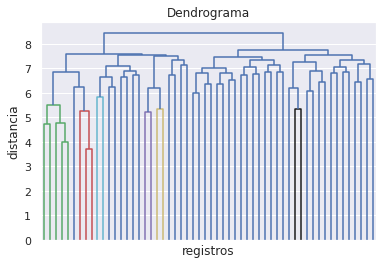

In [118]:
plt.figure()
plt.title('Dendrograma')#, ccc = %0.2f'%c)
plt.xlabel('registros')
plt.ylabel('distancia')
dn = dendrogram(z,no_labels=True,p=5, truncate_mode='level')  # show only the last p merged clusters

In [52]:
numclust = 10 # cortamos en 10 clusters
labels_ini = fcluster(z,numclust,criterion='maxclust') # los labels clasificando todo el GFP con dendrograma


Visualizando con otro metodo:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Remove the CWD from sys.path while we load stuff.


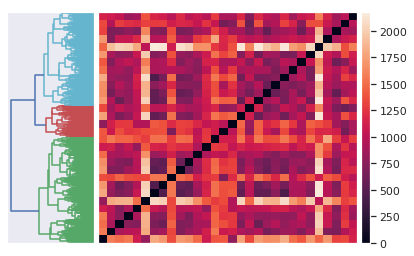

In [53]:
d1  = euclidean_distances(df_, df_) # escaleado
d2  = euclidean_distances(data,data)
#c,_= cophenet(z,Y=squareform(d))

# Abrir figura nueva
fig = pylab.figure()

# Calcular dendrograma y graficar.
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
Y = linkage(d1, method='average')
Z = dendrogram(Y, orientation='right')
axdendro.set_xticks([])
axdendro.set_yticks([])
axdendro.invert_xaxis()

# Graficar la matriz de distancias.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
index = Z['leaves']
d1 = d1[index,:]
d1 = d1[:,index]
im = axmatrix.matshow(d2, aspect='auto', origin='lower')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Graficar la barra de color
axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
pylab.colorbar(im, cax=axcolor)

Se ven 3 quiza 4 pero no es muy claro. Para encontrar el número óptimo es más completo calcular el Silhoette.

## (3.2) K-means modificado

In [54]:
# k means modificado funcion
# la diferencia de esta funcion con kmeans3 es que en esta los picos de gfp se calculan adentro y en la kmeans3 se ponen como parametro

def locmax(x):
    dx = np.diff(x) # discrete 1st derivative
    zc = np.diff(np.sign(dx)) # zero-crossings of dx
    m = 1 + np.where(zc == -2)[0] # indices of local max.
    return m

def kmeans(dat, n_maps, n_runs=10, maxerr=1e-6, maxiter=500): #data[gfp_peaks,:]=gfp_maps.T, gfp[gfp_peaks]=gfp_eval
  # input: datos, numero de clusters, cantidad de corridas, error y número maximo de iteraciones.
  # Output: 
    data=dat.transpose()
    n_t = data.shape[0]
    n_ch = data.shape[1]
    data = data - data.mean(axis=1, keepdims=True)

    # GFP peaks
    gfp = np.std(data, axis=1)
    gfp_peaks = locmax(gfp)
    gfp_values = gfp[gfp_peaks]
    gfp2 = np.sum(gfp_values**2) # normalizing constant in GEV
    n_gfp = gfp_peaks.shape[0]

    # clustering of GFP peak maps only
    V = data[gfp_peaks, :] # maps
    sumV2 = np.sum(V**2)

    # store results for each k-means run
    cv_list =   []  # cross-validation criterion for each k-means run
    gev_list =  []  # GEV of each map for each k-means run
    gevT_list = []  # total GEV values for each k-means run
    maps_list = []  # microstate maps for each k-means run
    L_list =    []  # microstate label sequence for each k-means run
    Llist =    []  # microstate label sequence for each k-means run gfp
    cv_gfp_list = [] # cross-validation criterion for each k-means run para gfp
  
    for run in range(n_runs):
        # initialize random cluster centroids 
        rndi = np.random.permutation(n_gfp)[:n_maps]
        maps = V[rndi, :] #V = data[gfp_peaks, :] 
        # normalize row-wise (across EEG channels)
        maps /= np.sqrt(np.sum(maps**2, axis=1, keepdims=True))
        # initialize
        n_iter = 0
        var0 = 1.0
        var1 = 0.0
        # convergence criterion: variance estimate (step 6)
        while ( (np.abs((var0-var1)/var0) > maxerr) & (n_iter < maxiter) ):
            # (step 3) microstate sequence (= current cluster assignment)
            C = np.dot(V, maps.T)
            C /= (n_ch*np.outer(gfp[gfp_peaks], np.std(maps, axis=1)))
            L = np.argmax(C**2, axis=1)
            # (step 4)
            for k in range(n_maps):
                Vt = V[L==k, :]
                # (step 4a)
                Sk = np.dot(Vt.T, Vt)
                # (step 4b)
                evals, evecs = np.linalg.eig(Sk)
                v = evecs[:, np.argmax(np.abs(evals))]
                v = v.real
                maps[k, :] = v/np.sqrt(np.sum(v**2))
            # (step 5)
            var1 = var0
            var0 = sumV2 - np.sum(np.sum(maps[L, :]*V, axis=1)**2)
            var0 /= (n_gfp*(n_ch-1))
            n_iter += 1
        if (n_iter > maxiter):
          print((f"\tK-means run {run+1:d}/{n_runs:d} did NOT converge "
                   f"after {maxiter:d} iterations."))
            #print((f"\tK-means run {run+1:d}/{n_runs:d} converged after "
            #       f"{n_iter:d} iterations."))
        #else:
        #    print((f"\tK-means run {run+1:d}/{n_runs:d} did NOT converge "
        #          f"after {maxiter:d} iterations."))

        # CROSS-VALIDATION criterion for this run (step 8)
        C_ = np.dot(data, maps.T)
        C_ /= (n_ch*np.outer(gfp, np.std(maps, axis=1)))
        L_ = np.argmax(C_**2, axis=1)
        # ¿no tendría que ser v?
        var = np.sum(data**2) - np.sum(np.sum(maps[L_, :]*data, axis=1)**2)
        var /= (n_t*(n_ch-1))
        cv = var * (n_ch-1)**2/(n_ch-n_maps-1.)**2

         # GEV (global explained variance) of cluster k
        gev = np.zeros(n_maps)
        for k in range(n_maps):
            r = L==k
            gev[k] = np.sum(gfp_values[r]**2 * C[r,k]**2)/gfp2
        gev_total = np.sum(gev)
        
        # store
        cv_list.append(cv)
        gev_list.append(gev)
        gevT_list.append(gev_total)
        maps_list.append(maps)
        L_list.append(L_)
        Llist.append(L)

    # select best run. Lo elige en función del validación cruzada
    k_opt = np.argmin(cv_list)
    gev = gev_list[k_opt]
    maps = maps_list[k_opt]
    L_ = L_list[k_opt]
    L  = Llist[k_opt]

    return maps, L_, L, k_opt,gev,gfp_peaks #maps_kmeans,labels_datos,labels_gfp,cv,GEV

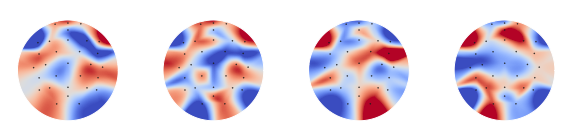

In [55]:
# Calculando para 5 clusters como ejemplo y graficando los centroides

n_clusters = 4

maps_kmeans,labels_datos,labels_gfp,cv,gev,gfp_peaks = kmeans(Todo_EEG, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

fig3, ax = plt.subplots(ncols=n_clusters, figsize=(10, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
for n in range(n_clusters):
    mne.viz.plot_topomap(maps_kmeans[n,:].T,info_eeg,
                         vmin=-0.3,vmax=0.3, cmap='coolwarm',
                         contours=0, axes=ax[n],show=False)
   # ax[n].set_title('gev='+str(round(100*gev[n],1))+'%', fontweight='bold')
plt.show()


In [56]:
# definicion funcion silhoette

def silhoutte_modificado2(maps,data,labels,ch,n_clusters):
    if data.shape[0]!=ch:
       data=data.T
    elif maps.shape[0]!=ch:
       maps=maps.T
    
    corr_ctodos =np.abs(np.corrcoef(data.T))
    sil = []
    for n,i in enumerate(data.T):
        L = labels[n]
        dist = 1-corr_ctodos[n,:]
        dist_=np.delete(dist,n)
        lab_ = np.delete(labels,n)
        prom_dist=[]
        for k in range(n_clusters):
            prom_dist.append(np.mean(dist_[lab_==k]))
        a=prom_dist[L]
        b=np.min(np.delete(prom_dist,L))
        sil.append((b-a)/np.max([a,b]))
    return sil

In [57]:
# Grafico silhoutte
def grafica_sil(n_clusters,sil,labels):
    import matplotlib.cm as cm
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.5, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(labels) + (n_clusters + 1) * 10])

    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = np.mean(sil)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = np.array(sil)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
   # ax1.set_xticks([-1,-0.5,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

In [58]:
ch    = Todo_EEG.shape[0]
samples = Todo_EEG.shape[1] 

n_clusters = 5

maps_kmeans,labels_datos,labels_gfp,cv,gev,gfp_peaks = kmeans(Todo_EEG, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

data=Todo_EEG.transpose()
data = data - data.mean(axis=1, keepdims=True)
gfp = np.std(data, axis=1)
gfp_peaks = locmax(gfp)
X = Todo_EEG[:,gfp_peaks]

sil = silhoutte_modificado2(maps_kmeans, X, labels_gfp, ch, n_clusters)


For n_clusters = 5 The average silhouette_score is : 0.1818244869474383


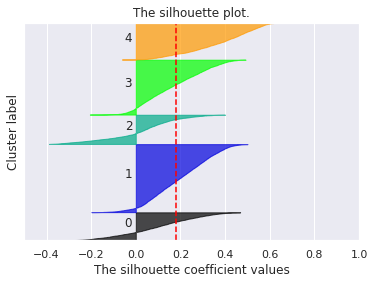

In [59]:
grafica_sil(n_clusters,sil,labels_gfp)

For n_clusters = 6 The average silhouette_score is : 0.17380129733875888


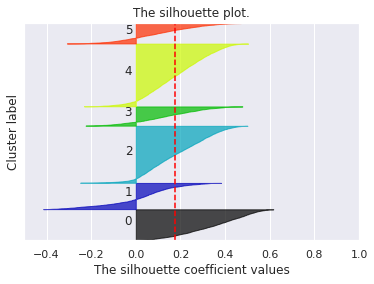

In [60]:
n_clusters = 6

maps_kmeans,labels_datos,labels_gfp,cv,gev,gfp_peaks = kmeans(Todo_EEG, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

sil = silhoutte_modificado2(maps_kmeans, X, labels_gfp, ch, n_clusters)
grafica_sil(n_clusters,sil,labels_gfp)

For n_clusters = 9 The average silhouette_score is : 0.15455967904849685


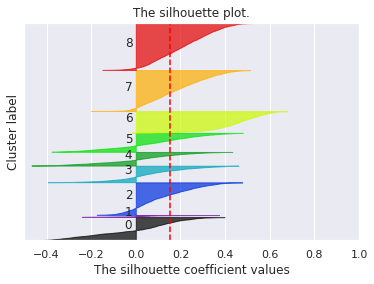

In [61]:
n_clusters = 9

maps_kmeans,labels_datos,labels_gfp,cv,gev,gfp_peaks = kmeans(Todo_EEG, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

sil = silhoutte_modificado2(maps_kmeans, X, labels_gfp, ch, n_clusters)
grafica_sil(n_clusters,sil,labels_gfp)

In [62]:
n_clusters =[2,3,4,5,6,7,8,9,10]
cv_nK = np.zeros_like(n_clusters)
sil_nK = []
for n_c in np.arange(len(n_clusters)):
  maps_kmeans,labels_datos,labels_gfp,cv,gev,gfp_peaks = kmeans(Todo_EEG, n_clusters[n_c], n_runs=10, maxerr=1e-6, maxiter=500)
  temp = silhoutte_modificado2(maps_kmeans, X,labels_gfp, ch,n_clusters[n_c])
  sil_nK=np.append(sil_nK,np.mean(temp))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


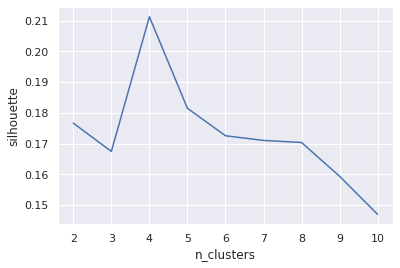

In [63]:
ax = sns.lineplot(n_clusters,sil_nK)
ax.set(xlabel ='n_clusters', ylabel ='silhouette')
plt.show()

COMO SE CALCULA EL ERROR EN EL SILHOETTE?

En numero optimo es cuatro clusters. Visualizando que tan buenos son esos clusters:

For n_clusters = 4 The average silhouette_score is : 0.21128182559687386


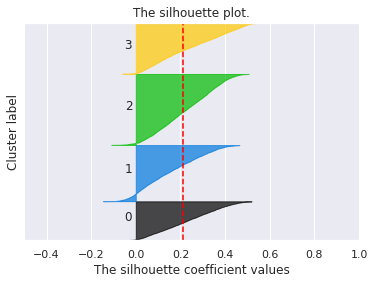

In [64]:
n_clusters = 4

maps_kmeans,labels_datos,labels_gfp,cv,GEV,gfp_peaks = kmeans(Todo_EEG, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

sil = silhoutte_modificado2(maps_kmeans, X, labels_gfp, ch, n_clusters)
grafica_sil(n_clusters,sil,labels_gfp)

### Varianza Explicada

In [65]:
n_clusters = 4

maps_kmeans,labels_datos,labels_gfp,cv,GEV,gfp_peaks = kmeans(Todo_EEG, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)


In [66]:
GEV

array([0.10909026, 0.29353342, 0.06395537, 0.17545523])

Para encontrar la varianza local, se suman los valores:


In [92]:
a = [0.10909026, 0.29353342, 0.06395537, 0.17545523]
EGV_4 =sum(a)
EGV_4

0.64203428

### Validacion cruzada

In [67]:
cv

77

### Varianza Explicada

In [68]:
n_clusters = 6

maps_kmeans,labels_datos,labels_gfp,cv,GEV,gfp_peaks = kmeans(Todo_EEG, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

In [73]:
labels_gfp.shape[0]

13136

In [69]:
GEV

array([0.08690748, 0.10954997, 0.10345281, 0.06718326, 0.24774972,
       0.0647672 ])

In [94]:
b= [0.08690748, 0.10954997, 0.10345281, 0.06718326, 0.24774972,0.0647672 ]
GEV_6 = sum(b)
GEV_6

0.6796104399999999

### Validacion cruzada

In [70]:
cv

89

### Varianza explicada

In [71]:
n_clusters = 10

maps_kmeans,labels_datos,labels_gfp,cv,GEV,gfp_peaks= kmeans(Todo_EEG, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

In [72]:
GEV

array([0.02721714, 0.06936873, 0.08130677, 0.0503775 , 0.03375754,
       0.00544642, 0.03213687, 0.08156303, 0.13401315, 0.20047509])

In [96]:
c = [0.02721714, 0.06936873, 0.08130677, 0.0503775 , 0.03375754, 0.00544642, 0.03213687, 0.08156303, 0.13401315, 0.20047509]
GEV_10 = sum(c)
GEV_10

0.7156622399999999

### Validacion cruzada

In [74]:
cv

29

In [111]:
n_clusters = [1,2,3,4,5,6,7,8,9,10]
Todo_GEV = []

for i in range(0,len(n_clusters)):
  maps_kmeans,labels_datos,labels_gfp,cv,GEV,gfp_peaks = kmeans(Todo_EEG, n_clusters[i], n_runs=100, maxerr=1e-6, maxiter=500)
  Todo_GEV.append(sum(GEV))

Todo_GEV

[0.47333218057304866,
 0.5547793334986428,
 0.6076252374975167,
 0.6420344525652197,
 0.6655825237447917,
 0.6796697150530386,
 0.6945538974379505,
 0.7035506016725925,
 0.7074191358828872,
 0.7164530689342914]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


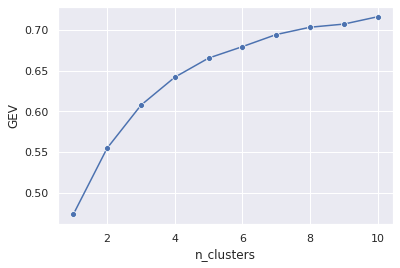

In [115]:
ax = sns.lineplot(n_clusters,Todo_GEV,marker="o")
ax.set(xlabel ='n_clusters', ylabel ='GEV')
plt.show()

In [108]:
n_clusters = [1,2]
for j in range(0,len(n_clusters)):
  print(n_clusters[j])


1
2


## Validacion Externa

### Matrices de confusion

In [75]:
EEG_todo_10 = Todo_EEG[:,gfp_peaks]

In [76]:
eeg_todo = pd.DataFrame(EEG_todo_10)
data = eeg_todo.sample(frac=1).reset_index(drop=True) # aleatorizando, frac es la proporcion de filas que devuelve

df = StandardScaler().fit_transform(data) # escalando

df_ = np.transpose(df) # para que clusterize columnas no filas
# indices random, para quedar con el 70% de df_ porque la RAM se muere con mas
#ind = np.random.choice(df_.shape[0], (int)(df_.shape[0]*0.7), replace=False)
#df_=df_[ind,]
z2 = linkage(df_, method='average', metric='euclidean')


numclust = 10 # cortamos en 10 clusters
labels_ini_10 = fcluster(z2,numclust,criterion='maxclust') # los labels clasificando todo el GFP con dendrograma


In [77]:
# labels originales obtenidas mediante metodo de dendrograma cortadas en 10 clusters
labels_ini_10

array([2, 8, 2, ..., 8, 6, 2], dtype=int32)

In [78]:
tmp = pd.DataFrame({'Labels': labels_ini_10, 'Clusters': labels_gfp})
ct0 = pd.crosstab(tmp['Labels'], tmp['Clusters']) # Create crosstab: ct
ct0

Clusters    0     1    2    3    4   5    6     7    8    9
Labels                                                     
1           2     1    2    2    3   0    1     5    1    0
2         204  1077  335  352  163   8  214  1189  532  585
3           2     0    0    3    5   3    1     5    0    0
4          54    51  128    9  219   8  461   126    9    4
5           2     1    5   21   20   2    0     3    2    0
6         311   148   29   54   35  20  122   121    5    7
7          13    17    5    7   18   7   20    13    9    1
8         403  1147  465  309  129  31  216  1003  568  606
9           1     2    2    1    1   0    4     1    0    0
10         69   123   37    6  147  22  711   312   35    3

Con 10 clusters solo le pegan "bien" tres etiquetas:

In [79]:
ct0_p = ct0
ct0 = ct0_p.to_numpy()
ct0.diagonal()

array([   2, 1077,    0,    9,   20,   20,   20, 1003,    0,    3])

In [80]:
n_clusters = 4

maps_kmeans,labels_datos,labels_gfp,cv,GEV,gfp_peaks= kmeans(Todo_EEG, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

# ahora las etiquetas del dendrograma

EEG_todo_4 = Todo_EEG[:,gfp_peaks]

eeg_todo = pd.DataFrame(EEG_todo_4)
data = eeg_todo.sample(frac=1).reset_index(drop=True) # aleatorizando, frac es la proporcion de filas que devuelve

df= StandardScaler().fit_transform(data) # escalando

df_ = np.transpose(df) # para que clusterize columnas no filas
# indices random, para quedar con el 70% de df_ porque la RAM se muere con mas
#ind = np.random.choice(df_.shape[0], (int)(df_.shape[0]*0.7), replace=False)
#df_=df_[ind,]
z3 = linkage(df_, method='average', metric='euclidean')


numclust = 4 # cortamos en 4 clusters
labels_ini_4 = fcluster(z3,numclust,criterion='maxclust') # los labels clasificando todo el GFP con dendrograma

In [81]:
tmp = pd.DataFrame({'Labels': labels_ini_4, 'Clusters': labels_gfp})
ct0 = pd.crosstab(tmp['Labels'], tmp['Clusters']) # Create crosstab: ct
ct0

Clusters     0     1     2     3
Labels                          
1         1384  1277  2004  1099
2          151   371   240   146
3           36    37    24    13
4         1507  1715  2036  1096

Se ven mejores resultados, pero le sigue pegando mal mucha veces. Usamos otras medidas porque probablemente es el dendrograma el que da una mala clasificacion.

### Van Dongen

In [82]:
ct0

Clusters     0     1     2     3
Labels                          
1         1384  1277  2004  1099
2          151   371   240   146
3           36    37    24    13
4         1507  1715  2036  1096

In [83]:
ct0[3]

Labels
1    1099
2     146
3      13
4    1096
Name: 3, dtype: int64

In [84]:
ct0[0]

Labels
1    1384
2     151
3      36
4    1507
Name: 0, dtype: int64

In [85]:
n2=2*(sum(ct0[0])+sum(ct0[1]))
sumi = sum(ct0.apply(np.max,axis=1))
sumj = sum(ct0.apply(np.max,axis=0))
maxsumi = np.max(ct0.apply(sum,axis=1))
maxsumj = np.max(ct0.apply(sum,axis=0))
vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
vd

0.9360313315926893

Como se esperaba, da muy mal, la matriz "pura" se diferencia un 96% de la matriz de confusion encontrada

### Efecto uniforme
Se puede calcular como el coeficiente de variación (CV = desvío estándar/media) de la distribución del tamaño de las clases. Valores del orden del 85% indica que el dendrograma esta formando clusters uniformes a pesar de que las clases estan desbalanceadas. El kmeans esta formando mejores clusters.

In [86]:
labd,cuentas_4d = np.unique(labels_ini_4, return_counts=True)  # cantidad de elementos en cada clase
labk,cuentas_4k = np.unique(labels_gfp, return_counts=True)

cv_dendro = np.std(cuentas_4d)/np.mean(cuentas_4d)
cv_kmeans = np.std(cuentas_4k)/np.mean(cuentas_4k)
cv_dendro, cv_kmeans

(0.8517340328889906, 0.21321949597738146)

### Indice Rand Ajustado

In [87]:
ari = adjusted_rand_score(labels_ini_4, labels_gfp)
ari

0.0027702312671934936

El indice es muy pequeño. Si las clases estan dadas por el dendrograma, el kmeans las estaria repartiendo mal.

En todo caso, los mapas de EEG en los puntos del GFP tienen tendencia al clustering? para responder, se calcula el coeficiente de Hopkins

### Estadistico de Hopkins

In [88]:
EEG_todo_4_ = EEG_todo_4.transpose()

d = EEG_todo_4.shape[0] # filas
n = EEG_todo_4.shape[1] # columnas
m = 1300 # cantidad de puntos al azar

nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(EEG_todo_4_) # buscador de vecinos

rand_ind = random.sample(range(0, n, 1), m) # indices al azar

ui = []
wi = []
for j in range(0, m):
    u_dist, _ = nbrs.kneighbors(np.random.normal(size=(1, d)).reshape(1, -1), 2, return_distance=True) # distancia a los nuevos puntos
    ui.append(u_dist[0][1])
    w_dist, _ = nbrs.kneighbors(EEG_todo_4_[rand_ind[j]].reshape(1, -1), 2, return_distance=True) # distancia a los puntos al azar
    wi.append(w_dist[0][1])

H = sum(wi) / (sum(ui) + sum(wi))
H

0.6443536190712986

Un coeficiente de Hopkins menor que 0,5 quiere decir que los puntos estan menos agrupados que los que se tiran al azar (si estandarizo los datos da menor, por que?)